# README #

Bu kısımda artık modelimizi kurup işi bitiriyoruz. Aşağıda her section için readme koyuyorum okuyabilirsiniz.

1. Import Libraries and Run Functions
    - Bu kısımda 2 adet sonradan kullanacağımız fonksiyonu yaratıyoruz. Biri plot_coefficients biri de plot_confusion_matrix.
    - plot_coefficients modeli kurmadan önce yaptığımız ön feature eleme süreci için kullanılıyor.
    - plot_confusion_matrix model sonucunu görmek için kullandığımız bir fonksiyon
    
    
2. Read the Data
    - Önceki aşamada yarattığımız csv dosyalarını okuyup train_x, train_y, test_x, test_y'ları oluşturuyoruz.


3. Select Features 
    - plot_coefficients fonksiyonunu kullanarak Support Vector Machine'den gelen feature importance'ları ekrana bar chart halinde yansıtıyoruz. Kırmızı barlar sonucu negatif yönde etkileyenler (ama kötü değil, bar uzun olduğu sürece iyi), mavi olanlar da pozitif yönde etkileyenler. Aşağıdaki 3 plot sırasıyla ev sahibi kazanır, berabere biter ve deplasman kazanır için feature'ların targeti nasıl etkilediğini gösteriyor.
    - Daha sonra, her feature'un her class için çıkarılan "coefficient"larının absolute değerlerini topluyoruz ve böylece elimize feature önemlerini gösteren bir liste geçiyor.
    - Bu listede en önemli feature'dan başlayarak diğer tüm feature'larla olan korelasyonları ölçüp %75'ten fazla korelasyonu olan feature eşlerinden daha önemsiz olan feature'u to_drop isimli bir listeye ekliyoruz. Onları modelde kullanmayacağız. Sebebi: overfittingi önlemek.
    - Bu işlemin sonunda elimizde 96 feature'dan 44 tanesi kaldı.
    
4. Model (Bu kısmı RANDOM FOREST için yazmıştım, Decision Tree ve Gradient Boosting için yorumları ROC score'lardan ve confusion matrixlerden yapabilirsiniz)
    > 4.1. Model Training
        - Random Forest modelini aşağıdaki parametreleri kullanarak çalıştırıyoruz:
            n_estimators=1800
            criterion='gini'
            max_depth=3
            min_samples_split=10
            min_samples_leaf=5
            random_state=17
            max_features=30
    > 4.2. Confusion Matrix
        - Model sonucunda prediction'larımızı ve gerçek değerleri bir matriste gösteriyoruz. Görebileceğiniz gibi model beraberliği hiç seçmiyor. Beraberliği açıklayan feature'lar az sayıda, dolayısıyla model hep bir tarafın yeneceği yönünde tahmin yapıyor. Yine de beraberlik için test datasından çıkan %60 ROC score fena sayılmaz.
    > 4.3. Model ROC Score
        - ROC skorlarımız Home win için 74% ve Away win için 77%'lerde. Bu çok iyi. Gerçekten iddia bile oynanabilir bu model kullanılarak. Beraberlik train datasında %71, test datasında %62. Çok iyi çıkmamış, biraz daha açıklayıcı feature lazım.
    > 4.4. Feature Importances
        - En iyi 15 feature'u çıkardığımızda takım market değerinin ve FIFA skor ortalamalarının çok açıklayıcı olduğu gözlemleniyor.

## 1. Import Libraries and Run Functions 

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

In [3]:
def plot_coefficients(coef, feature_names, top_features=20):
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1+ 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    return feature_names[top_positive_coefficients],coef[top_positive_coefficients],feature_names[top_negative_coefficients],coef[top_negative_coefficients]

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            pass
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm

## 2. Read the Data

In [5]:
train = pd.read_csv('./training_test_data/train.csv')
test = pd.read_csv('./training_test_data/test.csv')

train_x = train.copy()
train_y = train['TARGET']
test_x = test.copy()
test_y = test['TARGET']

train_x.drop('TARGET',inplace=True,axis=1)
test_x.drop('TARGET',inplace=True,axis=1)

## 3. Select Features

In [6]:
feature_names = list(train_x.columns)

In [7]:
train_x_norm = np.empty(train_x.shape)
count = 0
for col in feature_names:
    x = np.array(train_x[col])
    x_norm = x / np.linalg.norm(x)
    train_x_norm[:,count] = x_norm
    count+=1

In [8]:
svm = LinearSVC(C=0.001, penalty="l2", dual=True, max_iter=100000)
svm.fit(train_x_norm, train_y)

LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=100000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

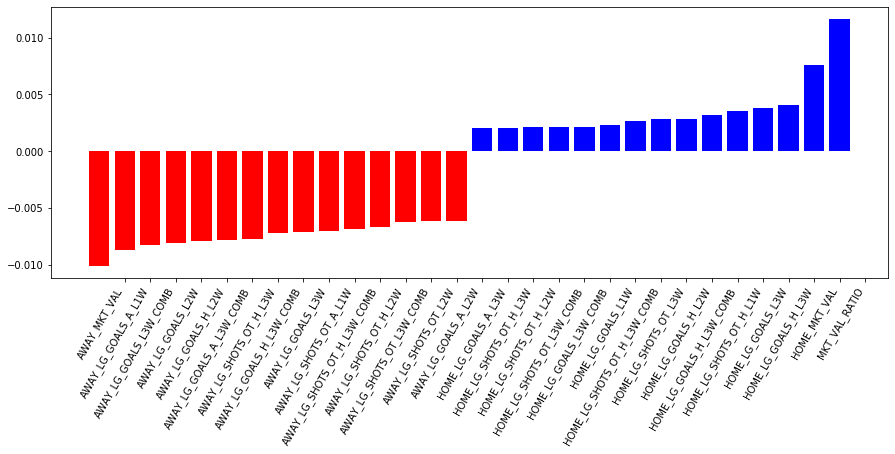

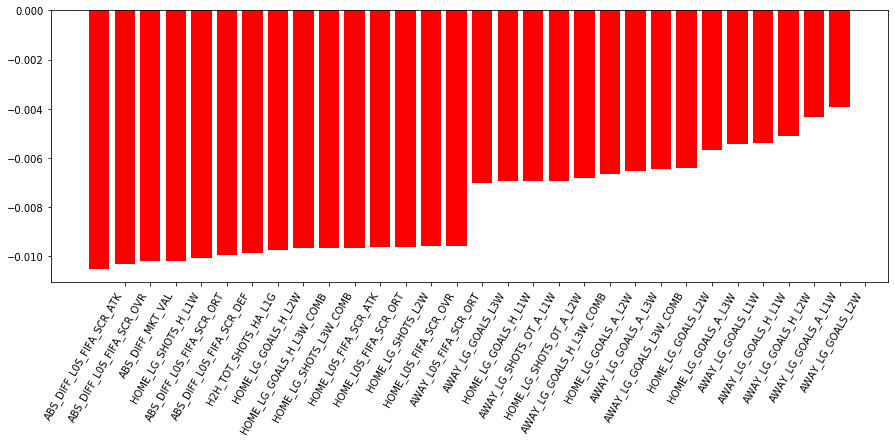

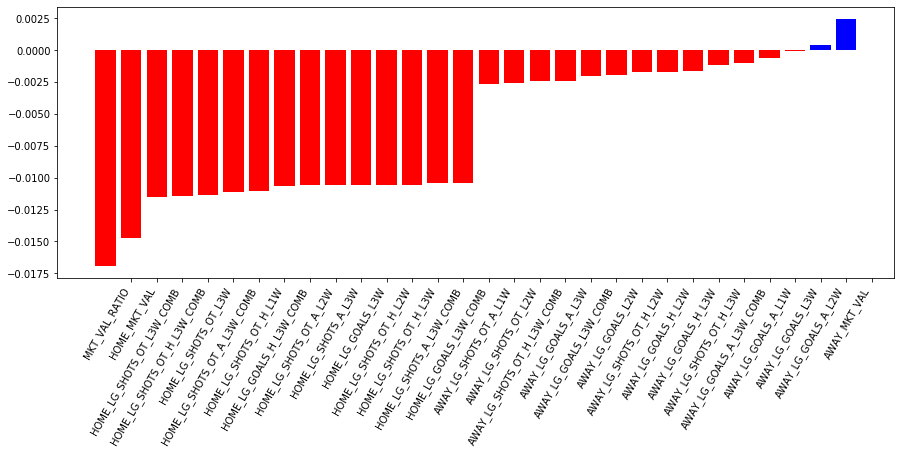

In [9]:
coef = svm.coef_
top_positive_features = []
top_negative_features = []
for i in range(3):
    pnames,pcoef, nnames, ncoef = plot_coefficients(coef[i],feature_names,15)
    top_positive_features.append((i+1,pnames,pcoef))
    top_negative_features.append((i+1,nnames,ncoef))

In [10]:
importances_1 = pd.DataFrame([top_positive_features[0][1],top_positive_features[0][2]]).T
importances_1.columns = ['feature','coef_1_positive']
importances_2 = pd.DataFrame([top_positive_features[1][1],top_positive_features[1][2]]).T
importances_2.columns = ['feature','coef_2_positive']
importances_3 = pd.DataFrame([top_positive_features[2][1],top_positive_features[2][2]]).T
importances_3.columns = ['feature','coef_3_positive']
importances_positive = importances_1.merge(importances_2,how='outer',on='feature').merge(importances_3,how='outer',on='feature')

In [11]:
importances_1 = pd.DataFrame([top_positive_features[0][1],top_positive_features[0][2]]).T
importances_1.columns = ['feature','coef_1_positive']
importances_2 = pd.DataFrame([top_positive_features[1][1],top_positive_features[1][2]]).T
importances_2.columns = ['feature','coef_2_positive']
importances_3 = pd.DataFrame([top_positive_features[2][1],top_positive_features[2][2]]).T
importances_3.columns = ['feature','coef_3_positive']
importances_positive = importances_1.merge(importances_2,how='outer',on='feature').merge(importances_3,how='outer',on='feature')

importances_1 = pd.DataFrame([top_negative_features[0][1],top_negative_features[0][2]]).T
importances_1.columns = ['feature','coef_1_negative']
importances_2 = pd.DataFrame([top_negative_features[1][1],top_negative_features[1][2]]).T
importances_2.columns = ['feature','coef_2_negative']
importances_3 = pd.DataFrame([top_negative_features[2][1],top_negative_features[2][2]]).T
importances_3.columns = ['feature','coef_3_negative']
importances_negative = importances_1.merge(importances_2,how='outer',on='feature').merge(importances_3,how='outer',on='feature')

In [12]:
importances = importances_positive.merge(importances_negative,how='outer',on='feature')
importances.set_index('feature',inplace=True)
importances['sum'] = importances.abs().sum(axis=1)
importances.sort_values('sum',ascending=False,inplace=True)

In [13]:
importances['rank'] = range(1,importances.shape[0]+1)

In [14]:
corr_matrix = train_x[importances.index.tolist()].corr().abs()

In [15]:
corr_matrix.to_excel('corr_matrix.xlsx')

In [16]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop=[]
for col in upper.columns:
    tmp = upper[col]>0.75
    compare_with = tmp[tmp==True].index.tolist()
    current_rank = importances.loc[col]['rank']
    if(len(compare_with)==0):
        continue
    else:
        win=0
        for col2 in compare_with:
            if current_rank > importances.loc[col2]['rank']:
                win+=1
        if(win==len(compare_with)):
            to_drop+=compare_with
        else:
            to_drop=col

In [17]:
model_features = [e for e in upper.columns.tolist() if e not in to_drop]

In [19]:
len(model_features)

44

## 4. Model (DECISION TREE)

In [55]:
from sklearn.tree import DecisionTreeClassifier

### 4.1. Model Training 

In [75]:
dt = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=8,
                             min_samples_split=6, 
                             min_samples_leaf=3, 
                             max_features=None, 
                             random_state=17, 
                             max_leaf_nodes=30)
dt.fit(train_x[model_features],train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=30,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

### 4.2. Confusion Matrix (TRAINING DATA)

In [76]:
train_y_prob = dt.predict_proba(train_x[model_features])
train_y_pred = dt.predict(train_x[model_features])

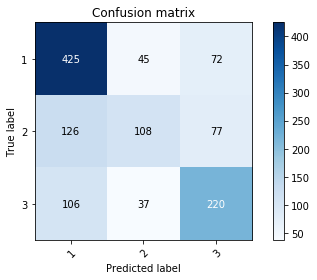

In [77]:
cm = plot_confusion_matrix(train_y, train_y_pred, classes=[1,2,3],
                      title='Confusion matrix')
plt.show()

In [78]:
accuracy = (cm[0,0] + cm[1,1] + cm[2,2]) / cm.sum() # Overall, how often is the classifier correct?
print('Accuracy: {}'.format(round(accuracy,2)))

Accuracy: 0.62


### 4.2. Confusion Matrix (TEST DATA)

In [79]:
test_y_prob = dt.predict_proba(test_x[model_features])
test_y_pred = dt.predict(test_x[model_features])

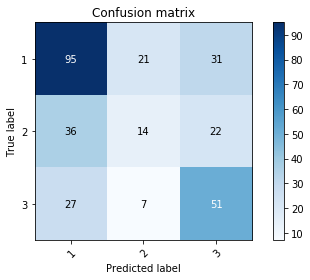

In [80]:
cm = plot_confusion_matrix(test_y, test_y_pred, classes=[1,2,3],
                      title='Confusion matrix')
plt.show()

In [81]:
accuracy = (cm[0,0] + cm[1,1] + cm[2,2]) / cm.sum() # Overall, how often is the classifier correct?
print('Accuracy: {}'.format(round(accuracy,2)))

Accuracy: 0.53


### 4.3. Model ROC Score (TRAINING DATA)

In [82]:
train_y_prob = dt.predict_proba(train_x[model_features])
train_y_pred = dt.predict(train_x[model_features])

In [83]:
train_y_prob_1 = [e[0] for e in train_y_prob]
train_y_prob_2 = [e[1] for e in train_y_prob]
train_y_prob_3 = [e[2] for e in train_y_prob]

In [84]:
train_y_1 = train_y.replace(3,0).replace(2,0)
train_y_2 = train_y.replace(1,0).replace(3,0).replace(2,1)
train_y_3 = train_y.replace(1,0).replace(2,0).replace(3,1)

In [85]:
fpr_1_train, tpr_1_train, _1_train = roc_curve(train_y_1, train_y_prob_1)
auc_1_train = roc_auc_score(train_y_1, train_y_prob_1)
fpr_2_train, tpr_2_train, _2_train = roc_curve(train_y_2, train_y_prob_2)
auc_2_train = roc_auc_score(train_y_2, train_y_prob_2)
fpr_3_train, tpr_3_train, _3_train = roc_curve(train_y_3, train_y_prob_3)
auc_3_train = roc_auc_score(train_y_3, train_y_prob_3)

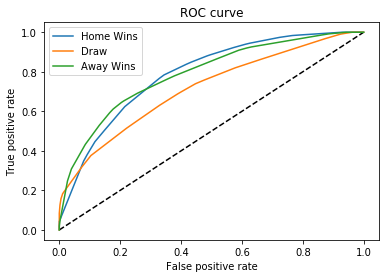

In [86]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1_train, tpr_1_train, label='Home Wins')
plt.plot(fpr_2_train, tpr_2_train, label='Draw')
plt.plot(fpr_3_train, tpr_3_train, label='Away Wins')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [87]:
print("AUC for Home Wins: "+str(auc_1_train))
print("AUC for Draw: "+str(auc_2_train))
print("AUC for Away Wins: "+str(auc_3_train))

AUC for Home Wins: 0.787959749033692
AUC for Draw: 0.7144126059227941
AUC for Away Wins: 0.7887087866838479


### 4.3. Model ROC Score (TEST DATA)

In [88]:
test_y_prob_1 = [e[0] for e in test_y_prob]
test_y_prob_2 = [e[1] for e in test_y_prob]
test_y_prob_3 = [e[2] for e in test_y_prob]

In [89]:
test_y_1 = test_y.replace(3,0).replace(2,0)
test_y_2 = test_y.replace(1,0).replace(3,0).replace(2,1)
test_y_3 = test_y.replace(1,0).replace(2,0).replace(3,1)

In [90]:
fpr_1, tpr_1, _1 = roc_curve(test_y_1, test_y_prob_1)
auc_1 = roc_auc_score(test_y_1, test_y_prob_1)
fpr_2, tpr_2, _2 = roc_curve(test_y_2, test_y_prob_2)
auc_2 = roc_auc_score(test_y_2, test_y_prob_2)
fpr_3, tpr_3, _3 = roc_curve(test_y_3, test_y_prob_3)
auc_3 = roc_auc_score(test_y_3, test_y_prob_3)

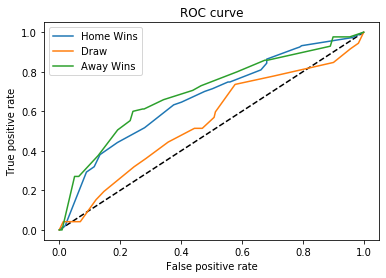

In [91]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Home Wins')
plt.plot(fpr_2, tpr_2, label='Draw')
plt.plot(fpr_3, tpr_3, label='Away Wins')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [92]:
print("AUC for Home Wins: "+str(auc_1))
print("AUC for Draw: "+str(auc_2))
print("AUC for Away Wins: "+str(auc_3))

AUC for Home Wins: 0.668139867411933
AUC for Draw: 0.5475035919540231
AUC for Away Wins: 0.6984689766317486


### 4.4. Feature Importances 

In [151]:
model_feature_importances = pd.DataFrame(zip(model_features,dt.feature_importances_),columns=['feature','importance'])
model_feature_importances = model_feature_importances.sort_values('importance',ascending=False).reset_index(drop=True)
model_feature_importances.iloc[:15]

,feature,importance
0,MKT_VAL_RATIO,0.245094
1,ABS_DIFF_L0S_FIFA_SCR_ORT,0.120656
2,HOME_L0S_FIFA_SCR_OVR,0.070544
3,HOME_LG_SHOTS_H_L1W,0.060324
4,H2H_TOT_SHOTS_HA_L1G,0.059523
5,HOME_LG_GOALS_A_L3W,0.050632
6,AWAY_LG_SHOTS_OT_H_L2W,0.049429
7,ABS_DIFF_L0S_FIFA_SCR_DEF,0.042424
8,AWAY_LG_GOALS_H_L2W,0.041425
9,AWAY_LG_GOALS_L3W_COMB,0.037282


## 4. Model (RANDOM FOREST)

### 4.1. Model Training 

In [36]:
rfr = RandomForestClassifier(n_estimators=1800, 
                            criterion='gini', 
                            max_depth=3, 
                            min_samples_split=10,
                            min_samples_leaf=5,
                            random_state=17,
                            verbose=0,
                            warm_start=False,
                            max_features=30)
rfr.fit(train_x[model_features],train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features=30, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

### 4.2. Confusion Matrix (TRAINING DATA)

In [37]:
train_y_prob = rfr.predict_proba(train_x[model_features])
train_y_pred = rfr.predict(train_x[model_features])

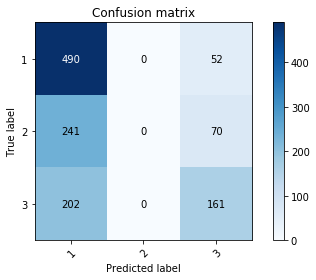

In [38]:
cm = plot_confusion_matrix(train_y, train_y_pred, classes=[1,2,3],
                      title='Confusion matrix')
plt.show()

In [39]:
accuracy = (cm[0,0] + cm[1,1] + cm[2,2]) / cm.sum() # Overall, how often is the classifier correct?
print('Accuracy: {}'.format(round(accuracy,2)))

Accuracy: 0.54


### 4.2. Confusion Matrix (TEST DATA)

In [40]:
test_y_prob = rfr.predict_proba(test_x[model_features])
test_y_pred = rfr.predict(test_x[model_features])

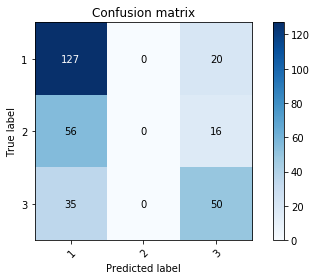

In [41]:
cm = plot_confusion_matrix(test_y, test_y_pred, classes=[1,2,3],
                      title='Confusion matrix')
plt.show()

In [42]:
accuracy = (cm[0,0] + cm[1,1] + cm[2,2]) / cm.sum() # Overall, how often is the classifier correct?
print('Accuracy: {}'.format(round(accuracy,2)))

Accuracy: 0.58


### 4.3. Model ROC Score (TRAINING DATA)

In [43]:
train_y_prob = rfr.predict_proba(train_x[model_features])
train_y_pred = rfr.predict(train_x[model_features])

In [44]:
train_y_prob_1 = [e[0] for e in train_y_prob]
train_y_prob_2 = [e[1] for e in train_y_prob]
train_y_prob_3 = [e[2] for e in train_y_prob]

In [45]:
train_y_1 = train_y.replace(3,0).replace(2,0)
train_y_2 = train_y.replace(1,0).replace(3,0).replace(2,1)
train_y_3 = train_y.replace(1,0).replace(2,0).replace(3,1)

In [46]:
fpr_1_train, tpr_1_train, _1_train = roc_curve(train_y_1, train_y_prob_1)
auc_1_train = roc_auc_score(train_y_1, train_y_prob_1)
fpr_2_train, tpr_2_train, _2_train = roc_curve(train_y_2, train_y_prob_2)
auc_2_train = roc_auc_score(train_y_2, train_y_prob_2)
fpr_3_train, tpr_3_train, _3_train = roc_curve(train_y_3, train_y_prob_3)
auc_3_train = roc_auc_score(train_y_3, train_y_prob_3)

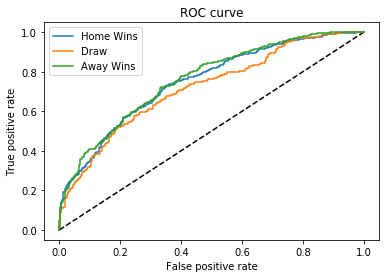

In [47]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1_train, tpr_1_train, label='Home Wins')
plt.plot(fpr_2_train, tpr_2_train, label='Draw')
plt.plot(fpr_3_train, tpr_3_train, label='Away Wins')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [48]:
print("AUC for Home Wins: "+str(auc_1_train))
print("AUC for Draw: "+str(auc_2_train))
print("AUC for Away Wins: "+str(auc_3_train))

AUC for Home Wins: 0.7489625192987834
AUC for Draw: 0.7180401840436303
AUC for Away Wins: 0.7600560652889332


### 4.3. Model ROC Score (TEST DATA)

In [49]:
test_y_prob_1 = [e[0] for e in test_y_prob]
test_y_prob_2 = [e[1] for e in test_y_prob]
test_y_prob_3 = [e[2] for e in test_y_prob]

In [50]:
test_y_1 = test_y.replace(3,0).replace(2,0)
test_y_2 = test_y.replace(1,0).replace(3,0).replace(2,1)
test_y_3 = test_y.replace(1,0).replace(2,0).replace(3,1)

In [51]:
fpr_1, tpr_1, _1 = roc_curve(test_y_1, test_y_prob_1)
auc_1 = roc_auc_score(test_y_1, test_y_prob_1)
fpr_2, tpr_2, _2 = roc_curve(test_y_2, test_y_prob_2)
auc_2 = roc_auc_score(test_y_2, test_y_prob_2)
fpr_3, tpr_3, _3 = roc_curve(test_y_3, test_y_prob_3)
auc_3 = roc_auc_score(test_y_3, test_y_prob_3)

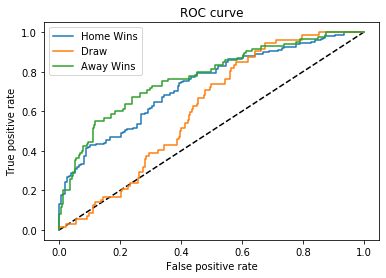

In [52]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Home Wins')
plt.plot(fpr_2, tpr_2, label='Draw')
plt.plot(fpr_3, tpr_3, label='Away Wins')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [53]:
print("AUC for Home Wins: "+str(auc_1))
print("AUC for Draw: "+str(auc_2))
print("AUC for Away Wins: "+str(auc_3))

AUC for Home Wins: 0.7336539711425971
AUC for Draw: 0.6124281609195403
AUC for Away Wins: 0.7730325006715015


### 4.4. Feature Importances 

In [54]:
model_feature_importances = pd.DataFrame(zip(model_features,rfr.feature_importances_),columns=['feature','importance'])
model_feature_importances = model_feature_importances.sort_values('importance',ascending=False).reset_index(drop=True)
model_feature_importances.iloc[:15]

,feature,importance
0,MKT_VAL_RATIO,0.342366
1,HOME_L0S_FIFA_SCR_OVR,0.166530
2,ABS_DIFF_L0S_FIFA_SCR_ORT,0.086711
3,AWAY_L0S_FIFA_SCR_ORT,0.068029
4,ABS_DIFF_L0S_FIFA_SCR_DEF,0.030686
5,AWAY_LG_SHOTS_OT_L3W_COMB,0.027448
6,AWAY_LG_SHOTS_OT_H_L3W,0.025393
7,AWAY_LG_SHOTS_OT_H_L2W,0.021171
8,AWAY_LG_GOALS_A_L3W_COMB,0.020135
9,AWAY_LG_GOALS_L3W_COMB,0.020018


## 4. Model (GRADIENT BOOSTING)

In [93]:
from sklearn.ensemble import GradientBoostingClassifier

### 4.1. Model Training 

In [132]:
gboost = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.0001, 
                                 n_estimators=10000,  
                                 criterion='friedman_mse', 
                                 min_samples_split=10, 
                                 min_samples_leaf=4, 
                                 max_depth=2,
                                 random_state=17,
                                 max_leaf_nodes=7,  
                                 n_iter_no_change=200)
gboost.fit(train_x[model_features],train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.0001, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=7,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=10000,
                           n_iter_no_change=200, presort='auto',
                           random_state=17, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### 4.2. Confusion Matrix (TRAINING DATA)

In [133]:
train_y_prob = gboost.predict_proba(train_x[model_features])
train_y_pred = gboost.predict(train_x[model_features])

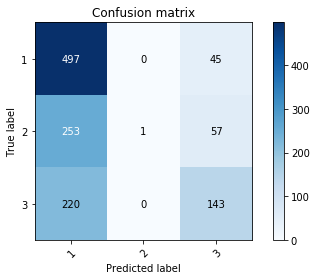

In [134]:
cm = plot_confusion_matrix(train_y, train_y_pred, classes=[1,2,3],
                      title='Confusion matrix')
plt.show()

In [135]:
accuracy = (cm[0,0] + cm[1,1] + cm[2,2]) / cm.sum() # Overall, how often is the classifier correct?
print('Accuracy: {}'.format(round(accuracy,2)))

Accuracy: 0.53


### 4.2. Confusion Matrix (TEST DATA)

In [136]:
test_y_prob = gboost.predict_proba(test_x[model_features])
test_y_pred = gboost.predict(test_x[model_features])

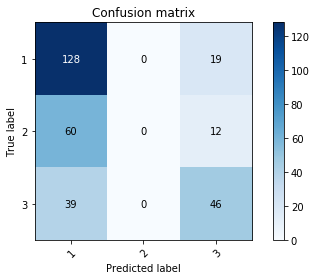

In [137]:
cm = plot_confusion_matrix(test_y, test_y_pred, classes=[1,2,3],
                      title='Confusion matrix')
plt.show()

In [138]:
accuracy = (cm[0,0] + cm[1,1] + cm[2,2]) / cm.sum() # Overall, how often is the classifier correct?
print('Accuracy: {}'.format(round(accuracy,2)))

Accuracy: 0.57


### 4.3. Model ROC Score (TRAINING DATA)

In [139]:
train_y_prob = gboost.predict_proba(train_x[model_features])
train_y_pred = gboost.predict(train_x[model_features])

In [140]:
train_y_prob_1 = [e[0] for e in train_y_prob]
train_y_prob_2 = [e[1] for e in train_y_prob]
train_y_prob_3 = [e[2] for e in train_y_prob]

In [141]:
train_y_1 = train_y.replace(3,0).replace(2,0)
train_y_2 = train_y.replace(1,0).replace(3,0).replace(2,1)
train_y_3 = train_y.replace(1,0).replace(2,0).replace(3,1)

In [142]:
fpr_1_train, tpr_1_train, _1_train = roc_curve(train_y_1, train_y_prob_1)
auc_1_train = roc_auc_score(train_y_1, train_y_prob_1)
fpr_2_train, tpr_2_train, _2_train = roc_curve(train_y_2, train_y_prob_2)
auc_2_train = roc_auc_score(train_y_2, train_y_prob_2)
fpr_3_train, tpr_3_train, _3_train = roc_curve(train_y_3, train_y_prob_3)
auc_3_train = roc_auc_score(train_y_3, train_y_prob_3)

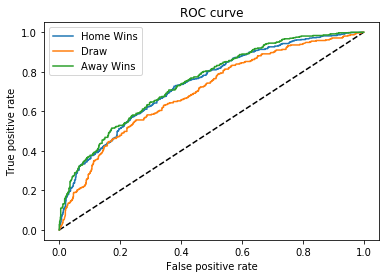

In [143]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1_train, tpr_1_train, label='Home Wins')
plt.plot(fpr_2_train, tpr_2_train, label='Draw')
plt.plot(fpr_3_train, tpr_3_train, label='Away Wins')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [144]:
print("AUC for Home Wins: "+str(auc_1_train))
print("AUC for Draw: "+str(auc_2_train))
print("AUC for Away Wins: "+str(auc_3_train))

AUC for Home Wins: 0.7353301871297645
AUC for Draw: 0.6976088539908689
AUC for Away Wins: 0.7474559083319608


### 4.3. Model ROC Score (TEST DATA)

In [145]:
test_y_prob_1 = [e[0] for e in test_y_prob]
test_y_prob_2 = [e[1] for e in test_y_prob]
test_y_prob_3 = [e[2] for e in test_y_prob]

In [146]:
test_y_1 = test_y.replace(3,0).replace(2,0)
test_y_2 = test_y.replace(1,0).replace(3,0).replace(2,1)
test_y_3 = test_y.replace(1,0).replace(2,0).replace(3,1)

In [147]:
fpr_1, tpr_1, _1 = roc_curve(test_y_1, test_y_prob_1)
auc_1 = roc_auc_score(test_y_1, test_y_prob_1)
fpr_2, tpr_2, _2 = roc_curve(test_y_2, test_y_prob_2)
auc_2 = roc_auc_score(test_y_2, test_y_prob_2)
fpr_3, tpr_3, _3 = roc_curve(test_y_3, test_y_prob_3)
auc_3 = roc_auc_score(test_y_3, test_y_prob_3)

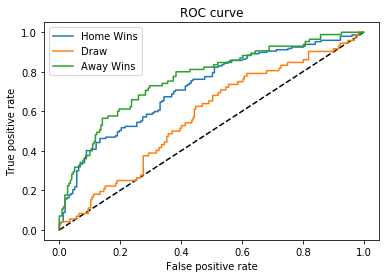

In [148]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Home Wins')
plt.plot(fpr_2, tpr_2, label='Draw')
plt.plot(fpr_3, tpr_3, label='Away Wins')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [149]:
print("AUC for Home Wins: "+str(auc_1))
print("AUC for Draw: "+str(auc_2))
print("AUC for Away Wins: "+str(auc_3))

AUC for Home Wins: 0.7204818233025694
AUC for Draw: 0.578334530651341
AUC for Away Wins: 0.7657534246575343


### 4.4. Feature Importances 

In [152]:
model_feature_importances = pd.DataFrame(zip(model_features,gboost.feature_importances_),columns=['feature','importance'])
model_feature_importances = model_feature_importances.sort_values('importance',ascending=False).reset_index(drop=True)
model_feature_importances.iloc[:15]

,feature,importance
0,MKT_VAL_RATIO,0.431533
1,HOME_L0S_FIFA_SCR_OVR,0.149239
2,ABS_DIFF_L0S_FIFA_SCR_ORT,0.113564
3,HOME_LG_SHOTS_H_L1W,0.034513
4,HOME_LG_GOALS_H_L2W,0.031497
5,HOME_LG_SHOTS_A_L3W,0.029661
6,AWAY_LG_GOALS_A_L3W_COMB,0.027904
7,AWAY_LG_GOALS_A_L1W,0.027784
8,AWAY_LG_SHOTS_OT_H_L3W,0.023788
9,HOME_LG_SHOTS_A_L3W_COMB,0.020976
